# Tutorial: Class Activation Maps for Semantic Segmentation
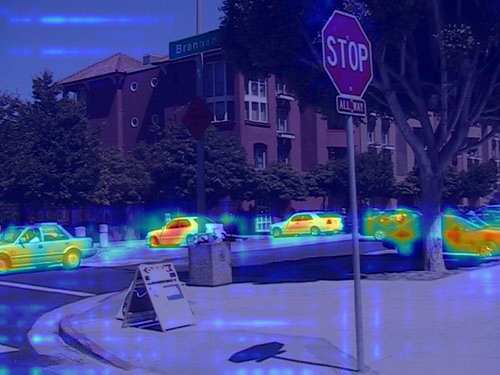

In this tutorial we're going to see how to apply Class Activation Maps for semantic segmentaiton, using deeplabv3_resnet50 from torchvision.

For classification the model predicts a list of the scores per category.
For Semantic Segmentation models, the model predicts these scores for every pixel in the image.

We need to compute the Class Activation MAP with respect to some target.
Usually the target to maximize the score of one of the categories.

For segmentation, we have more choice in this target since we have a spatial dimention in the output as well.
Some options, proposed by https://arxiv.org/abs/2002.11434 , are:
1. Looking at one of the pixels
2. Looking at all of the pixels from one of the cateogiries.

We're going to use the second option, as an example.

Getting this to work will require us to:
1. Define a model wrapper to get the output tensor, since the pytorch model outputs a custom dictionary.
2. Define a target class for semantic segmentaiton.


In [101]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


image_url = "https://farm1.staticflickr.com/6/9606553_ccc7518589_z.jpg"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


## Wait, the model output is a dictionary, it's not a Tensor!

This package assumes the model will output a tensor.
Here, instead, it's returning a dictionarty with the "out" and "aux" keys, where the actual result we care about is in "out".
This is a common issue with custom networks, sometimes the model outputs a tuple, for example, and maybe you care only about one of it's outputs.

To solve this we're going to wrap the model first.

In [102]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)


Now, lets run the model on the image, and show which pixels are predicted as belonging to the car mask.

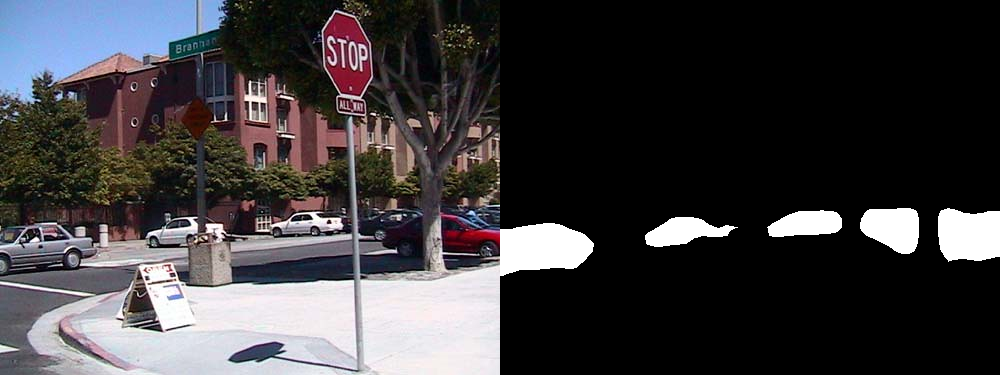

In [103]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

To apply a class activation method here, we need to decide about a few things:
    - What layer (or layers) are we going to work with?
    - What's going to be the target we want to maximize?

We're going to chose backbone.layer4 as an arbitrary choice that can be tuned.
You can print(model) and see which other layers you might want to try.

As for the target, we're going to take all the pixels that belong to the "car" category, and sum their predictions.

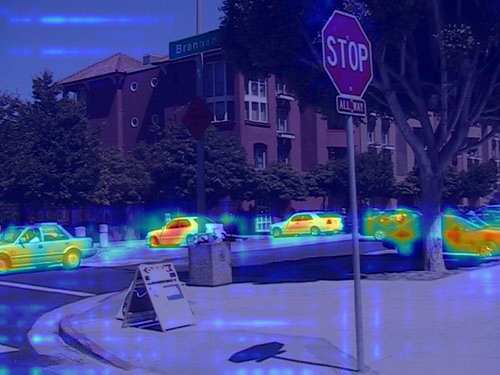

In [104]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)
    

Notice how we're getting pixels outside the otirinal masks as well. This is because every pixel is affected by it's sourrounding pixels as well.